# Simulating a pv Power plant

We begin by inventing a pv power plant at a location in Arizona and create some clearsky irradiance data for three days in 2016. Then we use pvlib to simulate our imaginary plant using this irradiance data.
Our goal is to use the result of the simulation and pretend it's measurement data.
Then we forget our power plant parameters and try to find them again by using genetic optimization.

The pv simulation part is inspired by this pvlib [tutorial](https://pvlib-python.readthedocs.io/en/stable/modelchain.html#a-simple-modelchain-example).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from copy import copy
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain

import seaborn as sns
sns.set()

Text(0,0.5,'Irradiance [W/m²]')

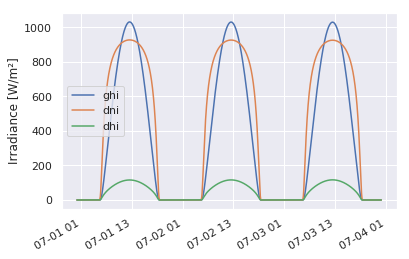

In [2]:
location = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

times = pd.DatetimeIndex(start='2016-07-01', end='2016-07-04', freq='1min', tz=location.tz)

cs = location.get_clearsky(times)  # ineichen with climatology table by default

cs.plot()
plt.ylabel("Irradiance [W/m²]")

In [3]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
sandia_module = sandia_modules[sandia_modules.columns[5]]
cec_inverter = cec_inverters[cec_inverters.columns[4]]

In [4]:
system = PVSystem(surface_tilt=20, surface_azimuth=188,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
mc = ModelChain(system, location)

In [5]:
cs['temp_air'] = 30

In [6]:
mc.run_model(times=cs.index, weather=cs)
gt_ts = mc.ac

Text(0,0.5,'simulated pv power')

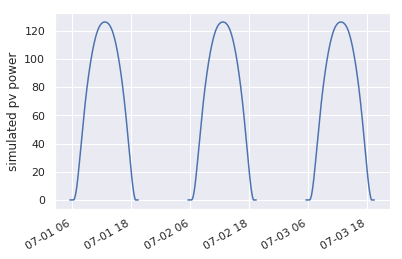

In [7]:
gt_ts.plot()
plt.ylabel("simulated pv power")

# Guess the system

Now that we have a system in place we can pretend that its result is a measurement and we can try to find the plant parameters that best describe this measurement.

Obviously guessing the system is not feasible, which is why we choose genetic optimization as a way to do it.

In [8]:
module_guess = sandia_modules[sandia_modules.columns[30]]
inverter_guess = cec_inverters[cec_inverters.columns[70]]

system2 = PVSystem(surface_tilt=20, surface_azimuth=190,
                  module_parameters=module_guess,
                  inverter_parameters=inverter_guess)
mc2 = ModelChain(system2, location)
mc2.run_model(times=cs.index, weather=cs)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

Text(0,0.5,'pv power')

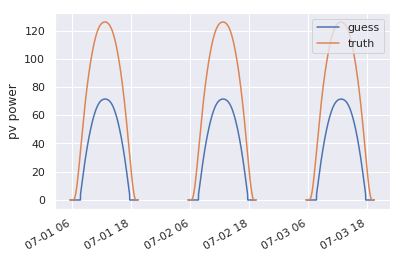

In [9]:
mc2.ac.plot(label="guess")
gt_ts.plot(label="truth")
plt.legend()
plt.ylabel("pv power")

# Radar charts

Plotting data in more than three dimensions is tricky. Our power plants are defined by four variables, which is why we choose radar charts as a way to plot them.

We also hope to plot entire populations of possible pv plants in a single radar chart and then use multiple charts as a way to visualize the genetic optimization process.
The code for the radar charts was inspired by [this](https://python-graph-gallery.com/391-radar-chart-with-several-individuals/).

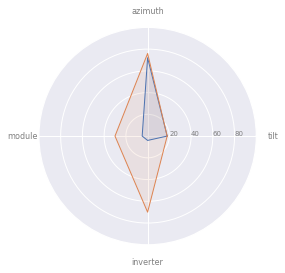

In [10]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'tilt': [18, 18],
'azimuth': [72, 76],
'module': [5, 30],
'inverter': [4, 70]
})
 
def radar_chart(df, lim=10, ax=None):
    # number of variable
    categories=list(df)[:]
    N = len(categories)
 
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    if ax == None:
        ax = plt.subplot(111, polar=True)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80], ["20","40","60", "80"], color="grey", size=7)
    plt.ylim(0,lim)
 

    for ind in range(len(df)):
        values=df.loc[ind].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        ax.fill(angles, values, alpha=0.1)
    return ax

radar_chart(df, lim=100)

# Genetic Optimization

For the genetic optimization we use the [deap](https://deap.readthedocs.io/en/master/) python package. We learned how to use the deap package from one of their [tutorials](https://deap.readthedocs.io/en/master/examples/ga_onemax.html).

The way it works is, we need to define  functions to create a population, functions for mutation and crossbreeding and an evaluation function which we minimize.
Deap can be used for either minimization or maximization depending on the weight used in the Fitness class.
We can either use pre defined functions from Deap or define our own functions and register them with the toolbox factory class.

In [11]:
from deap import base
from deap import creator
from deap import tools
import random

NOF_POS = 100

In [12]:
creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

toolbox = base.Toolbox()
toolbox.register("attr_", lambda l,m : random.randint(l,m), 0, NOF_POS)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_, 4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
modules = [sandia_modules[sandia_modules.columns[i]] for i in range(NOF_POS + 1)]
inverters = [cec_inverters[cec_inverters.columns[i]] for i in range(NOF_POS + 1)]
tilts = np.linspace(15, 45, NOF_POS + 1)
azimuths = np.linspace(180-20, 180+20, NOF_POS + 1)


def evalPlant(individual):
    module_guess = modules[individual[0]]
    inverter_guess = inverters[individual[1]]
    tilt_guess = tilts[individual[2]]   
    azimuth_guess = azimuths[individual[3]]
    
    system = PVSystem(surface_tilt=tilt_guess,
                    surface_azimuth=azimuth_guess,
                      module_parameters=module_guess,
                      inverter_parameters=inverter_guess)
    mc = ModelChain(system, location)
    mc.run_model(times=cs.index, weather=cs)
    
    return np.sqrt(((mc.ac - gt_ts)**2).mean()),

toolbox.register("evaluate", evalPlant)
evalPlant([5, 4, 18, 72])

(0.4605287543584266,)

In [14]:
def mutate(individual, indpb):
    retval = copy(individual)
    for ind in range(len(retval)):
        if random.random() < indpb:
            retval[ind] = random.randint(0, NOF_POS)
    return retval


toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Optimize

Now that all the necessary functions are defined and registered we can start the actual optimization.
We define a population size, probabilities for mutation and crossbreeding and a number of iterations/generations that we want to create.
We also keep track of subsets of every generation which we can plot later.

In [15]:
pop = toolbox.population(n=300)

gens = []
mins = []
avgs = []

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# CXPB  is the probability with which two individuals are crossed
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
    
# Begin the evolution
while g < 10:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    pop[:] = offspring
    
    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]
        
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
        
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
        
    gens.append(offspring[::10])
    mins.append(min(fits))
    avgs.append(mean)

-- Generation 1 --
  Min 4.762493787945748
  Max 73.94359420700292
  Avg 29.432028656673737
  Std 16.31507419751149
-- Generation 2 --
  Min 1.0485446173335684
  Max 53.83391913633678
  Avg 17.139346581409313
  Std 7.718508715671349
-- Generation 3 --
  Min 1.0485446173335684
  Max 31.67131602226784
  Avg 12.261698926553441
  Std 5.504246209588458
-- Generation 4 --
  Min 1.0485446173335684
  Max 20.634837600919845
  Avg 8.550043082701634
  Std 3.9206899669677293
-- Generation 5 --
  Min 1.0485446173335684
  Max 24.260121789887503
  Avg 5.925127775002789
  Std 3.357238893622403
-- Generation 6 --
  Min 0.9910886530157287
  Max 16.22960427566462
  Avg 3.7654841881332177
  Std 2.6946809523941835
-- Generation 7 --
  Min 0.4081422836958081
  Max 10.61937678439712
  Avg 2.1172553897245763
  Std 1.4769299643285305
-- Generation 8 --
  Min 0.36586654475384445
  Max 3.7514680871083166
  Avg 1.3718542339527933
  Std 0.4983815076715516
-- Generation 9 --
  Min 0.32804279011024484
  Max 2.685807

## Visualization of results

After running the optimization we have 10 generations that converged to an optimum.
Since genetic optimization does not guarantee a global optimum even for convex problems, we don't know if it is the best possible solution.

We can look at both how the best possible solution and the population as a whole has evolved over time using line/loss plots and our radar charts.

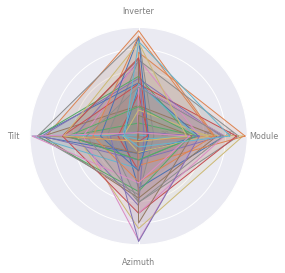

In [16]:
radar_chart(pd.DataFrame(np.array(gens[0]), columns=['Module', 'Inverter', 'Tilt', 'Azimuth']), lim=100)

Text(0.5,1,"Best and average root mean square error of\n power plant generations and 'measurement'")

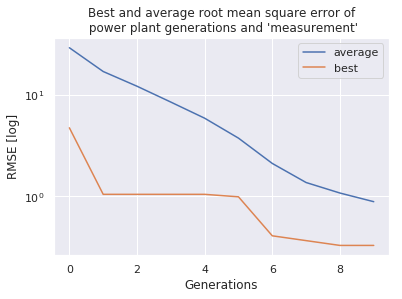

In [17]:
pd.DataFrame({'average': avgs, 'best': mins}).plot(logy=True)
plt.xlabel("Generations")
plt.ylabel("RMSE [log]")
plt.title("Best and average root mean square error of\n power plant generations and 'measurement'")